In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(7, 5))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'], scaling['node_h'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [7]:
scaling = build_dataframe(x_axis='mpi', factor=240)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  Time-Profile  io_ATMPROJ_pwscf  \
1  240     2      480     10         1        7680.0            0.0047   
0  480     2      960     20         1        4020.0            0.0048   
3  720     2     1440     30         1        2909.0            0.0043   
2  960     2     1920     40         1        2416.0            0.0014   

   io_KB_abinit   io_BS  io_Double_Grid  ...         Xo    GW(ppa)  \
1        0.0067  0.0047          0.0027  ...  1630.0000  1875.0000   
0        0.0056  0.0058          0.0021  ...   952.0000   870.0000   
3        0.0058  0.0061          0.0026  ...   683.0000   563.4003   
2        0.0030  0.0020          0.0028  ...   564.3314   463.5434   

   DIPOLE_transverse  Dipoles  ideal   speedup  efficiency  Self energy  \
1             4080.0   4080.0    1.0  1.000000  100.000000    1930.5403   
0             2055.0   2059.0    2.0  1.910448   95.522388     904.2691   
3             1408.0   1412.0    3.0  2.640083   88.002750     587.7938   
2             1067.0   1072.0    4.0  3.178808   79.470199     486.9930   

      Other     node_h  
1   37.1241  21.333333  
0  102.3469  22.333333  
3  223.8276  24.241667  
2  290.3278  26.844444  

[4 rows x 50 columns]

In [8]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile  Dipoles         Xo       X  Self energy     Other
1  240        7680.0   4080.0  1630.0000  2.3356    1930.5403   37.1241
0  480        4020.0   2059.0   952.0000  2.3840     904.2691  102.3469
3  720        2909.0   1412.0   683.0000  2.3786     587.7938  223.8276
2  960        2416.0   1072.0   564.3314  2.3478     486.9930  290.3278

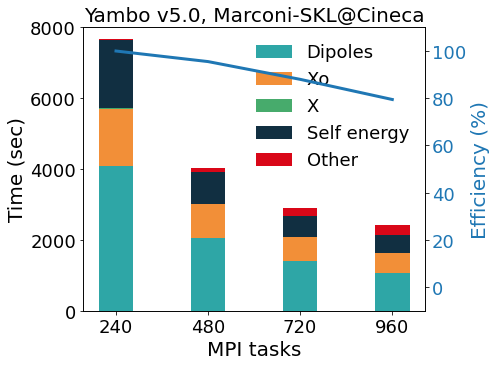

In [9]:
build_scaling_plot(scaling=scaling, 
                   pile=pile, colors=colors, bar_width=90, efficiency=True,
                   legend_loc='upper right', title=r'Yambo v5.0, Marconi-SKL@Cineca', 
                   file_name='scaling.png', y_lim=[0,8000])

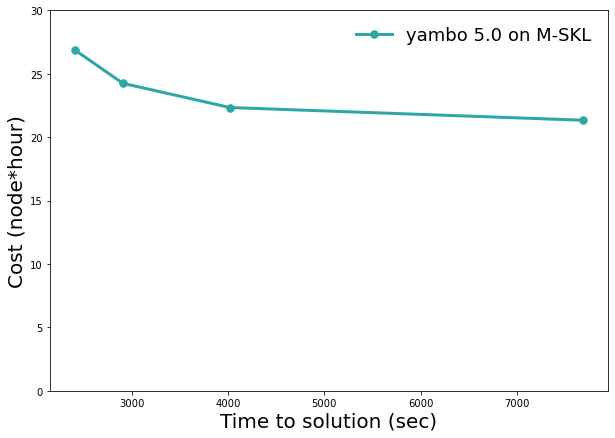

In [22]:
build_cost_plot(scaling=scaling, label='yambo 5.0 on M-SKL', y_lim=[0,30])

In [20]:
scaling

mpi  thrs  thr_tot  nodes  nodes_io  Time-Profile  io_ATMPROJ_pwscf  \
1  240     2      480     10         1        7680.0            0.0047   
0  480     2      960     20         1        4020.0            0.0048   
3  720     2     1440     30         1        2909.0            0.0043   
2  960     2     1920     40         1        2416.0            0.0014   

   io_KB_abinit   io_BS  io_Double_Grid  ...         Xo    GW(ppa)  \
1        0.0067  0.0047          0.0027  ...  1630.0000  1875.0000   
0        0.0056  0.0058          0.0021  ...   952.0000   870.0000   
3        0.0058  0.0061          0.0026  ...   683.0000   563.4003   
2        0.0030  0.0020          0.0028  ...   564.3314   463.5434   

   DIPOLE_transverse  Dipoles  ideal   speedup  efficiency  Self energy  \
1             4080.0   4080.0    1.0  1.000000  100.000000    1930.5403   
0             2055.0   2059.0    2.0  1.910448   95.522388     904.2691   
3             1408.0   1412.0    3.0  2.640083   88.002750     587.7938   
2             1067.0   1072.0    4.0  3.178808   79.470199     486.9930   

      Other     node_h  
1   37.1241  21.333333  
0  102.3469  22.333333  
3  223.8276  24.241667  
2  290.3278  26.844444  

[4 rows x 50 columns]